In [116]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import spacy

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [13]:
columns = ['identifier', 'nation', 'Category', 'Text']
sent = pd.read_csv("twitter_training.csv", names=columns, encoding='ISO-8859-1', on_bad_lines='skip')

In [15]:
sent.head()

,identifier,nation,Category,Text
0,2401,Borderlands,Negative,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Negative,I am coming to the borders and I will kill you...
2,2401,Borderlands,Negative,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Negative,im coming on borderlands and i will murder you...
4,2401,Borderlands,Negative,im getting on borderlands 2 and i will murder ...


In [18]:
sent.tail()

,identifier,nation,Category,Text
74641,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74642,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74643,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74644,9200,Nvidia,Positive,Just realized between the windows partition of...
74645,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [20]:
sent.shape

(74646, 4)

In [21]:
sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74646 entries, 0 to 74645
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   identifier  74646 non-null  int64 
 1   nation      74646 non-null  object
 2   Category    74646 non-null  object
 3   Text        73960 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [22]:
sent['Category'].value_counts()

Category
Negative      22540
Positive      20816
Neutral       18313
Irrelevant    12977
Name: count, dtype: int64

In [24]:
print(f"{sent['Text'][2]} -> {sent['Category'][2]}")

im getting on borderlands and i will kill you all, -> Negative


Preprocessing

In [25]:
# Remove missing values
sent.dropna(inplace=True)

# Text preprocessing function
nlp_model = spacy.load("en_core_web_sm")

def text_cleaning(input_text):
    doc = nlp_model(input_text)
    tokens_after_filtering = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        tokens_after_filtering.append(token.lemma_)
    
    return " ".join(tokens_after_filtering)


In [27]:
# Apply the text cleaning function to the 'Content' column
# Apply the text cleaning function to the 'Text' column
sent['Cleaned Text'] = sent['Text'].apply(text_cleaning)
sent

,identifier,nation,Category,Text,Cleaned Text
0,2401,Borderlands,Negative,im getting on borderlands and i will murder yo...,m get borderland murder
1,2401,Borderlands,Negative,I am coming to the borders and I will kill you...,come border kill
2,2401,Borderlands,Negative,im getting on borderlands and i will kill you ...,m get borderland kill
3,2401,Borderlands,Negative,im coming on borderlands and i will murder you...,m come borderland murder
4,2401,Borderlands,Negative,im getting on borderlands 2 and i will murder ...,m get borderland 2 murder
...,...,...,...,...,...
74641,9200,Nvidia,Positive,Just realized that the Windows partition of my...,realize Windows partition Mac like 6 year Nvid...
74642,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,realize Mac window partition 6 year Nvidia dri...
74643,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,realize window partition Mac 6 year Nvidia dri...
74644,9200,Nvidia,Positive,Just realized between the windows partition of...,realize window partition Mac like 6 year Nvidi...


In [33]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    sent['Cleaned Text'], 
    sent['Category'], 
    test_size=0.2, 
    random_state=42, 
    stratify=sent['Category']
)

In [34]:
x_test.shape

(14792,)

Naive Bayes

In [106]:
x_train.shape

(59168,)

In [107]:
nvb = Pipeline([
    ('vec', TfidfVectorizer(ngram_range=(1, 3))),  # 1-gram to 3-gram vectorization
    ('nb', MultinomialNB())  # Naive Bayes classifier
])


In [108]:
nvb.fit(x_train, y_train)

Pipeline(steps=[('vec', TfidfVectorizer(ngram_range=(1, 3))),
                ('nb', MultinomialNB())])

In [109]:
y_pred = nvb.predict(x_test)

In [110]:
print(accuracy_score(y_test, y_pred))

0.8618848025959979


              precision    recall  f1-score   support

  Irrelevant       0.99      0.64      0.78      2572
    Negative       0.79      0.96      0.87      4471
     Neutral       0.93      0.84      0.88      3621
    Positive       0.86      0.92      0.88      4128

    accuracy                           0.86     14792
   macro avg       0.89      0.84      0.85     14792
weighted avg       0.88      0.86      0.86     14792



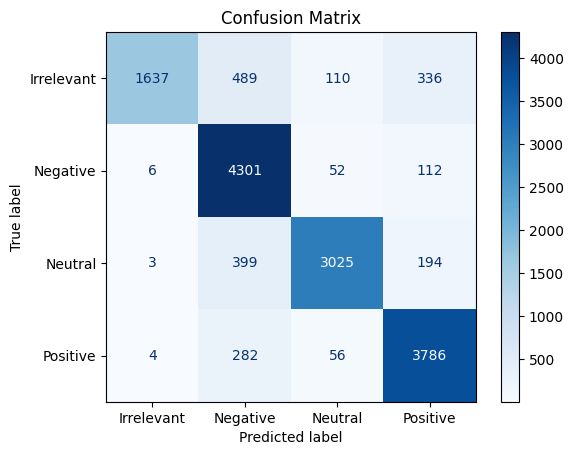

In [117]:
# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nvb.classes_)
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title("Confusion Matrix")
plt.show()


Random Forest

In [118]:
rmf = Pipeline([
    ('vectorizer_tri_grams', TfidfVectorizer()),
    ('naive_bayes', (RandomForestClassifier()))         
])

In [119]:
rmf.fit(x_train, y_train)

Pipeline(steps=[('vectorizer_tri_grams', TfidfVectorizer()),
                ('naive_bayes', RandomForestClassifier())])

In [120]:
y_pred = rmf.predict(x_test)

In [121]:
print(accuracy_score(y_test, y_pred))

0.9126554894537587


              precision    recall  f1-score   support

  Irrelevant       0.96      0.85      0.90      2572
    Negative       0.93      0.93      0.93      4471
     Neutral       0.94      0.90      0.92      3621
    Positive       0.85      0.95      0.90      4128

    accuracy                           0.91     14792
   macro avg       0.92      0.91      0.91     14792
weighted avg       0.92      0.91      0.91     14792



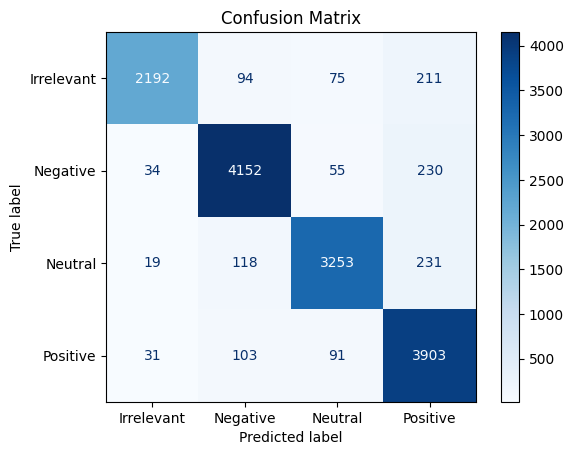

In [122]:
# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nvb.classes_)
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title("Confusion Matrix")
plt.show()

Testing

In [74]:
test_data = pd.read_csv('twitter_validation.csv', names=columns)

In [75]:
test_data.head()

,identifier,nation,Category,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [138]:
test_txt = test_data['Text'][14]
print(f"{test_txt} ===> {test_data['Category'][14]}")

@NBA2K game sucks... down by 2 with 38 seconds left and my team intentionally fouls ===> Negative


In [139]:
# Apply preprocess
test_txt_processed = [text_cleaning(test_txt)]
test_txt_processed

['@nba2 k game suck 2 38 second leave team intentionally foul']

In [140]:
test_txt1 = nvb.predict(test_txt_processed)
print(test_txt1)

['Negative']


In [141]:
test_txt2 = rmf.predict(test_txt_processed)
print(test_txt2)

['Negative']


In [142]:
classes = ['Irrelevant', 'Neutral', 'Negative', 'Positive']

print(f"True Label: {test_data['Category'][14]}")
print(f'Predict Label Naive Bayes: {test_txt1}')
print(f'Predict Label Random Forest: {test_txt2}')


True Label: Negative
Predict Label Naive Bayes: ['Negative']
Predict Label Random Forest: ['Negative']
